In [8]:
# Jupyter Notebook Chapter 9 and 10 Exercises Program
# DSC 530
# Week 8
# EDA Assignment Week 8
# David Berberena
# 2/4/2024

# Program Start

# Exercise 9-1

# As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the 
# effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.
# To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data.  You can use 
# thinkstats2.SampleRows to select a random subset of the rows in a DataFrame. What happens to the p-values of these tests 
# as sample size decreases? What is the smallest sample size that yields a positive test?

# Code taken from the Exercise file to establish the correct coding environment

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
import numpy as np

import random

import thinkstats2
import thinkplot

In [9]:
# More code taken to establish coding environment

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [10]:
# Code from the Exercise file establishing the HypothesisTest class

class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [11]:
# Code from the Exercise file establishing the DiffMeansPermute class

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [12]:
# Code from the Exercise file establishing the CorrelationPermute class

class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [13]:
# Code from the Exercise file establishing the PregLengthTest class

class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [16]:
# Final code to establish exercise assignment coding environment

import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [42]:
# Function is needed to combine all hypothesis tests in the chapter to be ran at once with a subset of the data
# The parameters of the function are the live dataset and the number of iterations, will be set to 1000)

def All_Hypothesis_Tests(live, iters=1000):

    # n is defined as the number of observations in the live dataset, and will be used to pull a random sample
    # First births and other births need to be pulled from the live dataset, specifically from the birthord variable
    
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # Permutation Test of pregnancy length will use the previously established DiffMeansPermute class which will take the
    # data as an argument and will be manipulated to return the p value using the 1000 iterations from the parent function
    
    data_1 = firsts.prglngth.values, others.prglngth.values
    h_test_1 = DiffMeansPermute(data_1)
    permutation_p_value = h_test_1.PValue(iters=iters)

    # Correlation Test of pregnancy of mother's age and birthweight will use the previously established CorrelationPermute 
    # class which will take the data as an argument and will be manipulated to return the p value using the 1000 iterations
    # from the parent function
    
    cleaned_data = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data_2 = cleaned_data.agepreg.values, cleaned_data.totalwgt_lb.values
    h_test_2 = CorrelationPermute(data_2)
    correlation_p_value = h_test_2.PValue(iters=iters)

    # Chi-Squared Test of pregnancy length will use the previously established PregLengthTest class which will take the
    # data as an argument and will be manipulated to return the p value using the 1000 iterations from the parent function
    
    data_1 = firsts.prglngth.values, others.prglngth.values
    h_test_3 = PregLengthTest(data_1)
    chi_p_value = h_test_3.PValue(iters=iters)

    print(n, permutation_p_value, correlation_p_value, chi_p_value)
    
# All_Hypothesis_Tests() function is called to run the three hypothesis tests on the random samples of the data that the 
# for loop below creates. I've chosen to conduct 10 sample tests to see the different sample sizes and their corresponding
# p-values for each test (Permutation, Correlation, and Chi-Squared)
    
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    All_Hypothesis_Tests(sample)
    
    # In the for loop, this floor division line of code must be written so that the sample size becomes smaller each time 
    # the for loop calls the All_Hypothesis_Tests() function. This allows us to see what happens to the p-values as the 
    # sample size decreases
    
    # After playing with the range, 7 is the number of tests I am able to do with the floor divisor of 2 without receiving 
    # a RunTimeWarning, which means that one of the p-values would be negative.
    
    n//=2

9148 0.159 0.0 0.0
4574 0.944 0.0 0.0
2287 0.184 0.002 0.0
1143 0.086 0.0 0.009
571 0.299 0.116 0.0
285 0.872 0.395 0.106
142 0.267 0.813 0.303


In [40]:
# Looking at the output of the p-values of all the hypothesis tests, we can see that as the sample size decreases, the 
# p-values for both permutation and chi-squared tests are sporadic in their behavior. Permutation p-values trend upward in 
# value, yet there are observations that show a decrease as well. For chi-squared tests, the trend also shows the p-values 
# increasing, yet they do so in a random fashion. The p-values for correlation tests seem to increase in an exponential way,
# seeing as the values go from less than 0.1 to 0.97 at the 7th set of tests.

# To find out the smallest sample size that yields a positive test each time it was ran, I had to play around with the floor
# divisor and the range of tests. I will run the code again to visualize the answer of 73 observations.

n = len(live)
for _ in range(4):
    sample = thinkstats2.SampleRows(live, n)
    All_Hypothesis_Tests(sample)
    n//=5

9148 0.169 0.0 0.0
1829 0.371 0.002 0.013
365 0.637 0.065 0.009
73 0.506 0.526 0.628


In [44]:
# Exercise 10-1

# Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best 
# present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying
# to guess someone’s weight, how much would it help to know their height? Like the NSFG, the BRFSS oversamples some groups 
# and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. 
# Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of 
# the mean, and a 90% confidence interval. How much does correct weighting affect the estimates? 
# Read the BRFSS data and extract heights and log weights.

# Code taken from the Exercise file to establish the correct coding environment

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

def ResampleRows(df):

    return SampleRows(df, len(df), replace=True)

In [45]:
# Computing of the least squares fit

# The slope and intercept are needed to realize the line of best fit for the dataset

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163932829, 0.005281454169417805)

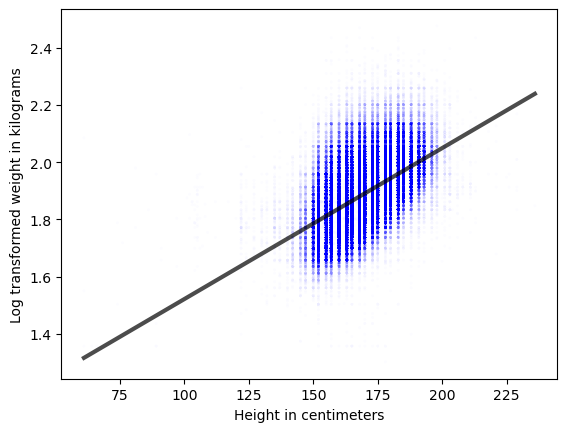

In [46]:
# Now that we have the slope and the intercept of the line of best fit, we can plot the line along with the data points 
# on a scatter plot using thinkplot's Scatter(), Plot(), and Config() functions as well as the previously defined 
# FitLine() function

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='black')
thinkplot.Config(xlabel='Height in centimeters', ylabel='Log transformed weight in kilograms', legend=False)

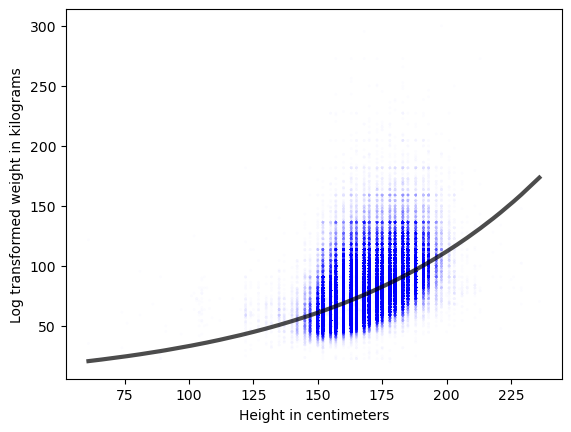

In [48]:
# In order to display this plot in the best way, we must compare the output to a plot that visualizes the relationship 
# between weight that has not been transformed and height 
# To visualize the non-transformed weights, when plotting the weights, they must reverted from log weights 
# back to normal weights (in the context of the plot, the log base of base must be squared by the fys variable) 

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='black')
thinkplot.Config(xlabel='Height in centimeters', ylabel='Log transformed weight in kilograms', legend=False)

In [59]:
# To see how much it would help to guess a person's weight based on knowing their height, we would need to look at the 
# residuals of the model, compute the correlation of the variables within the model along with the coefficient of 
# determination using the residuals. Once we verify that the correlation coefficient (p-value) squared equals the 
# coefficient of determination (r-squared), we can take the RSME (standard deviation) of both the weights and the residuals 
# to see the difference in the predictions that don't have any height information (log_weights) and those that do 
# (residuals) to realize the effect knowing the height can affect the weight prediction.

# The residuals of the model can be found with the previously established Residuals() function

res = thinkstats2.Residuals(heights, log_weights, inter, slope)

# P-value calculation can be performed using the built-in .Corr() function in the thinkstats2 library

p_value = thinkstats2.Corr(heights, log_weights)

# R-squared value can be determined using the previously established CoefDetermination() function 

r_squared_value = thinkstats2.CoefDetermination(log_weights, res)

# Print both values and check whether both values are the same when the p-value is squared

print(f'Correlation coefficient (P-Value): {p_value}')
print(f'Determination coefficient (R-Squared): {r_squared_value}')

# Using the numpy library's .isclose() function, we can see if the p squared value and the r squared value are 
# approximately the same number

print(f'P squared equals R squared: {np.isclose(p_value**2, r_squared_value)}')
 

Correlation coefficient (P-Value): 0.5317282605983434
Determination coefficient (R-Squared): 0.28273494311894065
P squared equals R squared: True


In [71]:
# Now to compute the RMSE values for weight predictions without and with height information

# RMSE values can be gleaned with the help of the .Std() built-in function from the thinkstats2 library

rmse_weights = thinkstats2.Std(log_weights)

rmse_residuals = thinkstats2.Std(res)

# The below formula allows us to realize the effect knowing height information has on the RMSE value 

1 - rmse_residuals / rmse_weights

# Print it all for readable viewing

print(f'The root mean squared error for weight predictions without any height information is {rmse_weights}')
print(f'The root mean squared error for weight predictions with height information is {rmse_residuals}')
print(f'The percent of effect that knowing height information has on '
      f'predictions is {(1 - rmse_residuals / rmse_weights)*100}')

The root mean squared error for weight predictions without any height information is 0.103207250300049
The root mean squared error for weight predictions with height information is 0.0874077708041609
The percent of effect that knowing height information has on predictions is 15.308497658793453


In [80]:
# Resampling with weights

# Summarize() function is taken from the Exercise code 

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    
# To resample the data with and without weights, the two previously established exercise functions ReSampleRows() and
# Summarize() are used

# To correctly utilize these functions, we need to go back to what the height variable is called in the original dataset, as
# these functions are calling the original dataset as input, meaning heights is back to being 'htm3'

# Unweighted resampling estimates

resample_est_no_weight = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(resample_est_no_weight)

mean, SE, CI 168.9563555498292 0.017500979043267046 (168.92498332625962, 168.98202772893552)


In [86]:
# Weighted resampling estimates using 'finalwt'

# ResampleRowsWeighted() function is taken from the Exercise code to weight the resampled estimates

def ResampleRowsWeighted(df, column):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

resample_est_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(resample_est_weighted)

mean, SE, CI 170.4971773125972 0.016744993055505315 (170.46781968107683, 170.52401776511246)


In [ ]:
# Looking at both the unweighted and weighted estimates, we can see that the mean height for the weighted estimates is about
# 1.5 centimeters taller than the estimates without any weight. The standard error (or sampling error) is not very different
# in terms of weighted versus unweighted estimates. 